In [4]:
# Lots to import!
import time
import numpy as np
import pandas as pd
import os
from bs4 import BeautifulSoup
import requests
import csv
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from datetime import date
from functools import reduce
from datetime import datetime
from collections import Counter
from dateutil.rrule import rrule, DAILY
from basketball_reference_web_scraper import client
from basketball_reference_web_scraper.data import Team
from basketball_reference_web_scraper.data import Outcome
from basketball_reference_web_scraper.data import Position

In [5]:
### Returns a pandas DataFrame with all players that led in points, assists and/or rebounds in any game
### in the given date range with a count for how many times they led in each stat, as well as how many times were in 
### wins and how many times were in losses

"""
What this code does:

Inspired by NBA Instagram's daily posts of each games top scorer from the winning teams
example: https://www.instagram.com/p/BtnEZkRALoR/
As part of a larger analysis from my Capstone project as to predicting the MVP and understanding what makes an MVP,
I had the hypothesis that this particular stat (how many times one leads their team during a win throughout a season)
might have a role in determining MVP, all-stars, or just how good a player is.

In this code, I scrape basketball reference for all box score data, and make a count how many times each player
led their team in a winning game in points, rebounds and assists, as well as in losing games, and combined.

The idea is that we can see if a player scores the most points when their team wins significantly more often 
than another player who is competing for the MVP vote (James Harden vs Giannis Antetokoumpo for instance, this season)
then that might be a solid argument to add to the narrative piece of their MVP vote.

The first group only counted leaders from teams in games that were won
Next group is just from games that were lost which could be interesting: Who are the best players on teams that usually lose?
Last dataset is combined- All games and all days considered - who led their teams the most in each stat in all games?

"""

def leaders_master(start_month, start_day, start_year, end_month, end_day, end_year):

    t0 = time.time() # Start timer to keep track how long code runs. Usually takes 1-5 minutes for one season.

    # Initialize my main lists which will store the top scorers, rebounds, etc for both wins and losses
    master_list_of_top_scorers=[]
    master_list_of_top_rebounders=[]
    master_list_of_top_assists=[]
    loser_list_of_top_scorers=[]
    loser_list_of_top_rebounders=[]
    loser_list_of_top_assists=[]

    # Sets the start and end date (including both ends) in format (YYYY, MM, DD), from 1999-2000 season onwards.
    a = date(start_year, start_month, start_day)
    b = date(end_year, end_month, end_day)

    for dt in rrule(DAILY, dtstart=a, until=b): # iterate over every day in the range

        monthh=dt.strftime("%m")
        dayy=dt.strftime("%d")
        yearr=dt.strftime("%Y")
        bs=client.player_box_scores(day=dayy, month=monthh, year=yearr) # Where the scraping occurs, using imported library
        df=pd.DataFrame(bs) # creates DataFrame from list of dictionaries; should include box score for that day

        if df.empty: # if no game was played that day
            print ("no games played on",monthh,dayy,yearr)
            continue  # we can jump to the next day if no games were played this day

        df['points']=df['made_free_throws']+2*(df['made_field_goals']-df['made_three_point_field_goals'])+3*df['made_three_point_field_goals'] #calculates points from shots made
        df['rebounds']=df['offensive_rebounds']+df["defensive_rebounds"] #calculates rebounds by adding both ORBs and DRBs

        df = df.astype({"outcome": str,'team':str}) #converts outcome into string so we can filter by win vs loss.
        df_win = df[df['outcome']=="Outcome.WIN"] #new df just for looking at winning teams
        df_lose = df[df['outcome']=="Outcome.LOSS"] #new df just for looking at losing teams

        for winning_team in set(df_win['team']):  #for each team that won on this day

            df_new = df_win[df_win['team']==winning_team] #new df just for one team at a time
            idx_points = df_new.loc[df_new['points'].idxmax()] #finds the row/player with most points
            master_list_of_top_scorers.append(idx_points['name']) #adds top scorer to list

            idx_rebound = df_new.loc[df_new['rebounds'].idxmax()] #finds the row/player with most rebounds
            master_list_of_top_rebounders.append(idx_rebound['name']) #adds top rebounder to list

            idx_assist = df_new.loc[df_new['assists'].idxmax()] #finds the row/player with most assists
            master_list_of_top_assists.append(idx_assist['name']) #adds top assister to list

#             #Unhash the following three lines if you want to see the code printing each game leader as it is scraping each day (to check progress)
#             print (winning_team,"top assister on", monthh, dayy, yearr, "(win): ",idx_assist['name'])
#             print (winning_team,"top rebounder on", monthh, dayy, yearr, "(win): ",idx_rebound['name'])
#             print (winning_team,"top scorer on", monthh, dayy, yearr, "(win): ",idx_points['name'])

        for losing_team in set(df_lose['team']):  #for each team that lost on this day

            df_new = df_lose[df_lose['team']==losing_team] #new df just for one team at a time
            idx_points = df_new.loc[df_new['points'].idxmax()] #finds the row/player with most points
            loser_list_of_top_scorers.append(idx_points['name']) #adds top scorer to list

            idx_rebound = df_new.loc[df_new['rebounds'].idxmax()] #finds the row/player with most rebounds
            loser_list_of_top_rebounders.append(idx_rebound['name']) #adds top rebounder to list

            idx_assist = df_new.loc[df_new['assists'].idxmax()] #finds the row/player with most assists
            loser_list_of_top_assists.append(idx_assist['name']) #adds top assister to list
        
        print ("Done scraping day:",monthh,dayy,yearr)

#            #Unhash the following three lines if you want to see the code printing each game leader as it is scraping each day (to check progress)
#             print (losing_team,"top assister on", monthh, dayy, yearr, "(loss): ",idx_assist['name'])
#             print (losing_team,"top rebounder on", monthh, dayy, yearr, "(loss): ",idx_rebound['name'])
#             print (losing_team,"top scorer on", monthh, dayy, yearr, "(loss): ",idx_points['name'])

    t1 = time.time() # end timer and print total time
    total = t1-t0
    print ("total time scraping:",total,"seconds")
    
    #Convert the lists to sorted lists of each players count of total led games per category with most first
    points_leaders=sorted(list(Counter(master_list_of_top_scorers).items()), key=lambda tup: tup[1],reverse=True)
    points_leaders_df=pd.DataFrame(points_leaders).rename(index=str,columns={0:"player",1:"point_lead_count_wins"})

    rebound_leaders=sorted(list(Counter(master_list_of_top_rebounders).items()), key=lambda tup: tup[1],reverse=True)
    rebound_leaders_df=pd.DataFrame(rebound_leaders).rename(index=str,columns={0:"player",1:"rebound_lead_count_wins"})

    assist_leaders=sorted(list(Counter(master_list_of_top_assists).items()), key=lambda tup: tup[1],reverse=True)
    assist_leaders_df=pd.DataFrame(assist_leaders).rename(index=str,columns={0:"player",1:"assist_lead_count_wins"})

    loser_points_leaders=sorted(list(Counter(loser_list_of_top_scorers).items()), key=lambda tup: tup[1],reverse=True)
    loser_points_leaders_df=pd.DataFrame(loser_points_leaders).rename(index=str,columns={0:"player",1:"point_lead_count_losses"})

    loser_rebound_leaders=sorted(list(Counter(loser_list_of_top_rebounders).items()), key=lambda tup: tup[1],reverse=True)
    loser_rebound_leaders_df=pd.DataFrame(loser_rebound_leaders).rename(index=str,columns={0:"player",1:"rebound_lead_count_losses"})

    loser_assist_leaders=sorted(list(Counter(loser_list_of_top_assists).items()), key=lambda tup: tup[1],reverse=True)
    loser_assist_leaders_df=pd.DataFrame(loser_assist_leaders).rename(index=str,columns={0:"player",1:"assist_lead_count_losses"})

    combined_points_leaders=Counter(dict(points_leaders))
    combined_points_leaders.update(dict(loser_points_leaders))
    combined_points_leaders=sorted(list(Counter(combined_points_leaders).items()), key=lambda tup: tup[1],reverse=True)
    combined_points_leaders_df=pd.DataFrame(combined_points_leaders).rename(index=str,columns={0:"player",1:"point_lead_count_total"})

    combined_assist_leaders=Counter(dict(assist_leaders))
    combined_assist_leaders.update(dict(loser_assist_leaders))
    combined_assist_leaders=sorted(list(Counter(combined_assist_leaders).items()), key=lambda tup: tup[1],reverse=True)
    combined_assist_leaders_df=pd.DataFrame(combined_assist_leaders).rename(index=str,columns={0:"player",1:"rebound_lead_count_total"})

    combined_rebound_leaders=Counter(dict(rebound_leaders))
    combined_rebound_leaders.update(dict(loser_rebound_leaders))
    combined_rebound_leaders=sorted(list(Counter(combined_rebound_leaders).items()), key=lambda tup: tup[1],reverse=True)
    combined_rebound_leaders_df=pd.DataFrame(combined_rebound_leaders).rename(index=str,columns={0:"player",1:"assist_lead_count_total"})
    
    #Next I merge all the dataframes to return just one dataframe with all my data
    dfs=[points_leaders_df,rebound_leaders_df,assist_leaders_df,loser_points_leaders_df,loser_rebound_leaders_df,loser_assist_leaders_df,combined_points_leaders_df,combined_assist_leaders_df,combined_rebound_leaders_df]
    df_master = reduce(lambda left,right:pd.merge(left,right,how='outer'),dfs).fillna(0).set_index('player').sort_values(["point_lead_count_wins","rebound_lead_count_wins",'assist_lead_count_wins'],ascending=False)
    return (df_master)


In [6]:
%matplotlib inline 

#This function visualizes the stat leaders (in winning games) with Plotly
#If you want a full season just enter the end_year to season_year and any value for others
#example: graph_leaders(1,2,3,1,2,3,season_year=2015) or graph_leaders(10,25,2017,4,13,2018)
# Will not run for years before 2000 as basketball_reference_web_scraper only works for years after 2000

def graph_leaders(start_month, start_day, start_year, end_month, end_day, end_year,season_year = None):
    
    if season_year in range(1987,2020): #Check if we are running a full season for which we have csv's scraped already
        master_df = pd.read_csv(f"./season_leaders/season_leaders_{season_year}.csv").set_index("player")
        dat = pd.DataFrame(client.players_season_totals(season_end_year=season_year)).set_index('name') #scrape player data for positions
    else:
        print("Creating new leader dataset for your date range") #Create df with all leader data by calling leaders above:
        master_df = leaders_master(start_month, start_day, start_year, end_month, end_day, end_year) #choose date range here
        dat=pd.DataFrame(client.players_season_totals(season_end_year=end_year)).set_index('name')
    
    master = master_df[['point_lead_count_wins','rebound_lead_count_wins','assist_lead_count_wins']] #you can change wins here to see stats in losses/combined

    dat.index=dat.index.str.replace('*','') #Removes Hall of Fame star for HOF players
    dat = dat[~dat.index.duplicated(keep='last')]
    dat["positions"] =[i[0].name for i in dat['positions']]
    dat=dat[["positions"]]
    master['positions']=np.nan
    for player, stat in master.iterrows():
        master.loc[player,'positions'] = dat['positions'][player]

    #Create categorical numbers for color coding players by position
    master["positions_cat"]= master["positions"].astype('category')
    cat_columns = master.select_dtypes(['category']).columns
    master[cat_columns]=master[cat_columns].apply(lambda x: x.cat.codes)

    data = [go.Scatter3d(
        x=master['point_lead_count_wins'],
        y=master['rebound_lead_count_wins'],
        z=master['assist_lead_count_wins'],
        mode='markers+text',
        marker=dict(
            size=12,
            color=master['positions_cat'],                # set color to an array/list of desired values
            colorscale='Viridis',   # choose a colorscale
            opacity=0.7,),
        text=master.index)]

    fig = go.Figure(data=data, layout=go.Layout(margin=dict(l=0,r=0,b=0,t=0,)))
    plotly.tools.set_credentials_file(username='yoel', api_key='X5zJSEMhmqO4FtkCmjcj')
    return py.iplot(fig, filename='3d-scatter-colorscale')
    
#graph_leaders(2017,10,17,2018,4,11)
#graph_leaders(1,1,2019,2,1,2019)

In [7]:
#THIS BLOCK IS TO SCRAPE SEASON SCHEDULES FOR EACH YEAR

def get_response(url):
    print(f"Requesting \'{url}\'")
    try:
        r = requests.get(url)
        text = r.text
        return BeautifulSoup(text, 'lxml')
    except requests.exceptions.RequestException as e:
        print(e)
    return None

data=[]
for year in range(1988,2020):
    if year==2000:
        second = 2000
    elif year>2000 and year<2010:
        second = f"{year-2000:02d}"
    elif year>2009:
        second = year-2000
    else:
        second = year-1900
    yeary = str(year-1)+"-"+str(second)
    url = f"https://en.wikipedia.org/wiki/{yeary}_NBA_season"
    soup = get_response(url)
    table = soup.find('table', attrs={'class':'infobox'})
    hrow = table.find_all('td')
    hrow = [ele.text.strip() for ele in hrow]
    data.append([ele for ele in hrow if ele][2])
data


Requesting 'https://en.wikipedia.org/wiki/1987-88_NBA_season'
Requesting 'https://en.wikipedia.org/wiki/1988-89_NBA_season'
Requesting 'https://en.wikipedia.org/wiki/1989-90_NBA_season'
Requesting 'https://en.wikipedia.org/wiki/1990-91_NBA_season'
Requesting 'https://en.wikipedia.org/wiki/1991-92_NBA_season'
Requesting 'https://en.wikipedia.org/wiki/1992-93_NBA_season'
Requesting 'https://en.wikipedia.org/wiki/1993-94_NBA_season'
Requesting 'https://en.wikipedia.org/wiki/1994-95_NBA_season'
Requesting 'https://en.wikipedia.org/wiki/1995-96_NBA_season'
Requesting 'https://en.wikipedia.org/wiki/1996-97_NBA_season'
Requesting 'https://en.wikipedia.org/wiki/1997-98_NBA_season'
Requesting 'https://en.wikipedia.org/wiki/1998-99_NBA_season'
Requesting 'https://en.wikipedia.org/wiki/1999-2000_NBA_season'
Requesting 'https://en.wikipedia.org/wiki/2000-01_NBA_season'
Requesting 'https://en.wikipedia.org/wiki/2001-02_NBA_season'
Requesting 'https://en.wikipedia.org/wiki/2002-03_NBA_season'
Reques

['Nov 6, 1987\xa0– Apr 24, 1988Apr 28\xa0– Jun 4, 1988 (Playoffs)Jun 7–21, 1988 (Finals)',
 'Nov 4, 1988\xa0– Apr 23, 1989Apr 27\xa0– Jun 2, 1989 (Playoffs)Jun 6–13, 1989 (Finals)',
 'November 3, 1989 – April 22, 1990  April 26 – June 3, 1990 (Playoffs)  June 5 – 14, 1990 (Finals)',
 'November 2, 1990 – April 21, 1991  April 25 – May 30, 1991 (Playoffs)  June 2 – 12, 1991 (Finals)',
 'November 1, 1991 – April 19, 1992  April 23 – May 29, 1992 (Playoffs)  June 3 – 14, 1992 (Finals)',
 'November 6, 1992 – April 25, 1993April 29 – June 5, 1993 (Playoffs)June 9 – 20, 1993 (Finals)',
 'November 5, 1993 – April 24, 1994  April 28 – June 5, 1994 (Playoffs)  June 8 – 22, 1994 (Finals)',
 'November 4, 1994 – April 23, 1995  April 27 – June 4, 1995 (Playoffs)  June 7 – 14, 1995 (Finals)',
 'November 3, 1995 – April 21, 1996  April 25 – June 2, 1996 (Playoffs)  June 5 – 16, 1996 (Finals)',
 'November 1, 1996 – April 20, 1997  April 24 – May 29, 1997 (Playoffs)  June 1 – 13, 1997 (Finals)',
 'Octo

In [8]:
# Pull out date text
for i in range(len(data)):
    print (data[i][:34])

Nov 6, 1987 – Apr 24, 1988Apr 28 –
Nov 4, 1988 – Apr 23, 1989Apr 27 –
November 3, 1989 – April 22, 1990 
November 2, 1990 – April 21, 1991 
November 1, 1991 – April 19, 1992 
November 6, 1992 – April 25, 1993A
November 5, 1993 – April 24, 1994 
November 4, 1994 – April 23, 1995 
November 3, 1995 – April 21, 1996 
November 1, 1996 – April 20, 1997 
October 31, 1997 – April 19, 1998 
February 5 – May 5, 1999  May 8 – 
November 2, 1999 – April 19, 2000 
October 31, 2000 – April 18, 2001 
October 30, 2001 – April 17, 2002 
October 29, 2002 – April 16, 2003 
October 28, 2003 – April 14, 2004 
November 2, 2004 – April 20, 2005 
November 1, 2005 – April 19, 2006 
October 31, 2006 – April 18, 2007 
October 30, 2007 – April 16, 2008 
October 28, 2008 – April 16, 2009 
October 27, 2009 – April 14, 2010 
October 26, 2010 – April 13, 2011 
December 25, 2011 – April 26, 2012
October 30, 2012 – April 17, 2013 
October 29, 2013 – April 16, 2014 
October 28, 2014 – April 15, 2015 
October 27, 2015 – A

In [22]:
#CLEANS UP AND FORMATS DATE RANGES

p="""11, 6, 1987 – Apr 24, 1988
11, 4, 1988 – Apr 23, 1989
11, 3, 1989 – April 22
11, 2, 1990 – April 21
11, 1, 1991 – April 19
11, 6, 1992 – April 25
11, 5, 1993 – April 24
11, 4, 1994 – April 23
11, 3, 1995 – April 21
11, 1, 1996 – April 20
10, 31, 1997 – April 19
2, 5, 1999 – 5, 5, 1999
11, 2, 1999 – April 19
10, 31, 2000 – April 18
10, 30, 2001 – April 17
10, 29, 2002 – April 16
10, 28, 2003 – April 14
11, 2, 2004 – April 20
11, 1, 2005 – April 19
10, 31, 2006 – April 18
10, 30, 2007 – April 16
10, 28, 2008 – April 16
10, 27, 2009 – April 14
10, 26, 2010 – April 13
11, 25, 2011 – April 2
10, 30, 2012 – April 17
10, 29, 2013 – April 16
10, 28, 2014 – April 15
10, 27, 2015 – April 13
10, 25, 2016 – April 12
10, 17, 2017 – April 11
10, 16, 2018, 4, 10, 2019"""
dates=p.splitlines()
for i in range(len(dates)):
    dates[i] = dates[i].replace(" – April ",", 4, ")
    dates[i] = dates[i].replace("– Apr ",", 4, ")
    dates[i] = dates[i].replace(" – ",", ")
    if i!=11:
        if len(dates[i])<24:
            dates[i] = dates[i]+","+str(range(1988,2020)[i])
    dates[i] = [int(value) for value in dates[i].split(",")]
dates[31] = [10, 16, 2018, 3, 11, 2019] #adjust for current day - can change this to current day if you run again or delete line if you run after april 10 2019

#CHECK IF FORMAT IS GOOD FOR INPUT TO OUR FUNCTION
for season_dates in dates:
    print (season_dates)


[11, 6, 1987, 4, 24, 1988]
[11, 4, 1988, 4, 23, 1989]
[11, 3, 1989, 4, 22, 1990]
[11, 2, 1990, 4, 21, 1991]
[11, 1, 1991, 4, 19, 1992]
[11, 6, 1992, 4, 25, 1993]
[11, 5, 1993, 4, 24, 1994]
[11, 4, 1994, 4, 23, 1995]
[11, 3, 1995, 4, 21, 1996]
[11, 1, 1996, 4, 20, 1997]
[10, 31, 1997, 4, 19, 1998]
[2, 5, 1999, 5, 5, 1999]
[11, 2, 1999, 4, 19, 2000]
[10, 31, 2000, 4, 18, 2001]
[10, 30, 2001, 4, 17, 2002]
[10, 29, 2002, 4, 16, 2003]
[10, 28, 2003, 4, 14, 2004]
[11, 2, 2004, 4, 20, 2005]
[11, 1, 2005, 4, 19, 2006]
[10, 31, 2006, 4, 18, 2007]
[10, 30, 2007, 4, 16, 2008]
[10, 28, 2008, 4, 16, 2009]
[10, 27, 2009, 4, 14, 2010]
[10, 26, 2010, 4, 13, 2011]
[11, 25, 2011, 4, 2, 2012]
[10, 30, 2012, 4, 17, 2013]
[10, 29, 2013, 4, 16, 2014]
[10, 28, 2014, 4, 15, 2015]
[10, 27, 2015, 4, 13, 2016]
[10, 25, 2016, 4, 12, 2017]
[10, 17, 2017, 4, 11, 2018]
[10, 16, 2018, 3, 11, 2019]


In [14]:
#WRITE ALL SEASON LEADERS TO CSV, takes about 30 minutes to run. Remove """ to run code.
"""
import os
for season_dates in dates[12:]:
    df = leaders_master(season_dates[0], season_dates[1], season_dates[2], season_dates[3], season_dates[4], season_dates[5])
    outname = f"season_leaders_{season_dates[5]}.csv"
    outdir = './season_leaders'
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    fullname = os.path.join(outdir, outname)    
    df.to_csv(fullname)
"""


'\nimport os\nfor season_dates in dates[12:]:\n    df = leaders_master(season_dates[0], season_dates[1], season_dates[2], season_dates[3], season_dates[4], season_dates[5])\n    outname = f"season_leaders_{season_dates[5]}.csv"\n    outdir = \'./season_leaders\'\n    if not os.path.exists(outdir):\n        os.mkdir(outdir)\n    fullname = os.path.join(outdir, outname)    \n    df.to_csv(fullname)\n'

In [10]:
# SCRAPE 2019 MVP Predictions from Basketball reference

data = []
url = "https://www.basketball-reference.com/friv/mvp.html"
soup = get_response(url)
if not soup:
    print("STOP")
table = soup.find('table', attrs={'id':'players'})
table_head = table.find('thead')
hrow = table_head.find_all('tr')[0]
hcols = hrow.find_all('th')
hcols = [ele.text.strip() for ele in hcols]
data.append([ele for ele in hcols if ele])
table_body = table.find('tbody')
rows = table_body.find_all('tr')
rank = 0
for row in rows:
    rank += 1
    line = [rank]
    cols = [ele.text.strip() for ele in row.find_all('td')]
    line += [ele for ele in cols]
    data.append([ele for ele in line if ele])
mvp_predict = pd.DataFrame(data)
mvp_predict.columns = mvp_predict.iloc[0]
mvp_predict = mvp_predict.reindex(mvp_predict.index.drop(0))
mvp_prob = mvp_predict[['Player',"Prob%"]].set_index("Player")
mvp_prob["Prob%"] = mvp_prob["Prob%"].map(lambda x: x.rstrip('%'))
mvp_prob = mvp_prob.rename(columns={"Prob%":"Share"})
mvp_prob["Share"]=mvp_prob["Share"].astype(float)

#COMBINE LEADER COUNT WITH MVP VOTING DATA

df_list=[]
for year in range(2000,2020):
    print ("Year is", year)        
    leader_df = pd.read_csv(f'./season_leaders/season_leaders_{year}.csv')
    leader_df['year'] = year
    leader_df = leader_df.rename(columns={'player':'Player'})
    if year!=2019:
        mvp_df = pd.read_csv(f'./scrapedata/mvp_voting_{year}.csv')
    else:
        mvp_df = mvp_prob
    mvp_df['year'] = year
    mvp_df['is_mvp']=0
    mvp_df['is_mvp'][0]=1
    mix_df=leader_df.merge(mvp_df,on=['year','Player'],how='inner').set_index("Player")
    mix_df["pra"]=mix_df["point_lead_count_wins"]+mix_df["rebound_lead_count_wins"]+mix_df["assist_lead_count_wins"]
    mix_df["total_pra"]=mix_df["point_lead_count_total"]+mix_df["rebound_lead_count_total"]+mix_df["rebound_lead_count_total"]
    mix_df["total_prank"]=mix_df["total_pra"].rank(ascending=False)
    mix_df["pra_rank"] = mix_df["pra"].rank(ascending=False) 
    
    df_list.append(mix_df)


Requesting 'https://www.basketball-reference.com/friv/mvp.html'
Year is 2000


/Users/crazyforcandy1234/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Year is 2001
Year is 2002
Year is 2003
Year is 2004
Year is 2005
Year is 2006
Year is 2007
Year is 2008
Year is 2009
Year is 2010
Year is 2011
Year is 2012
Year is 2013
Year is 2014
Year is 2015
Year is 2016
Year is 2017
Year is 2018
Year is 2019


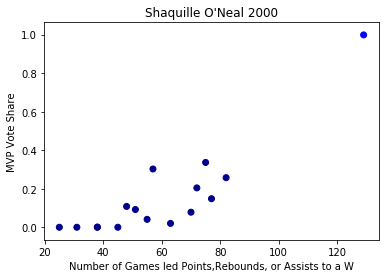

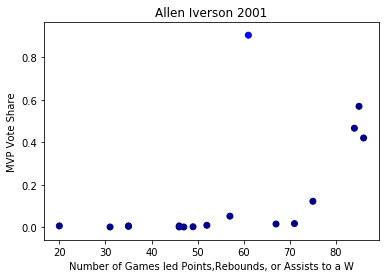

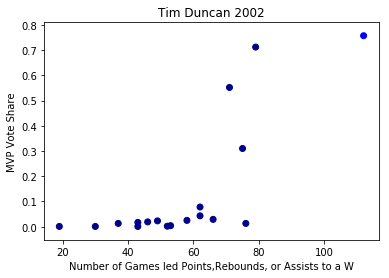

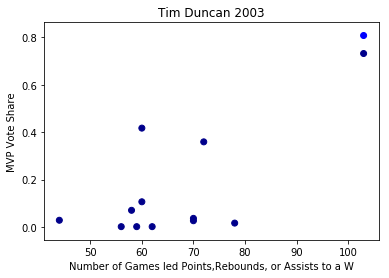

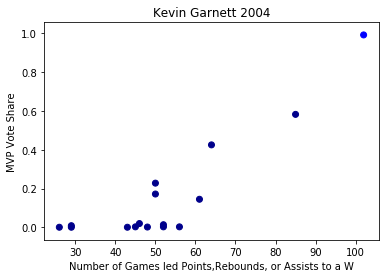

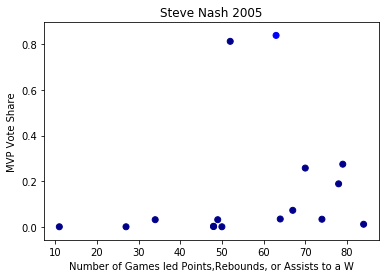

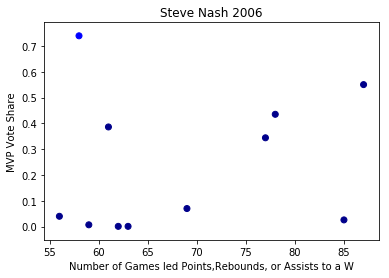

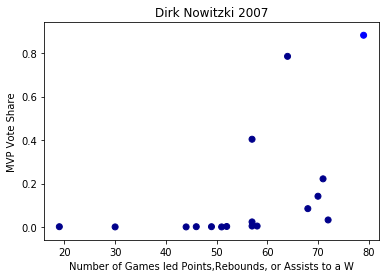

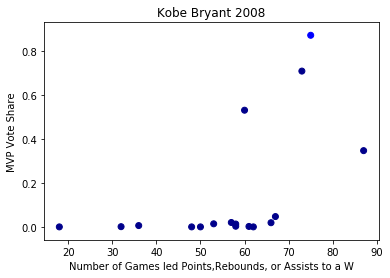

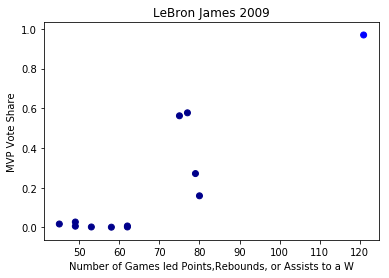

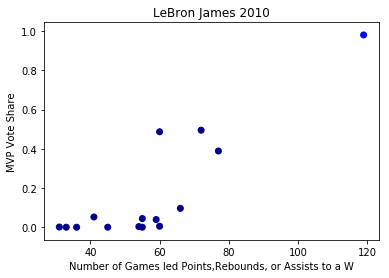

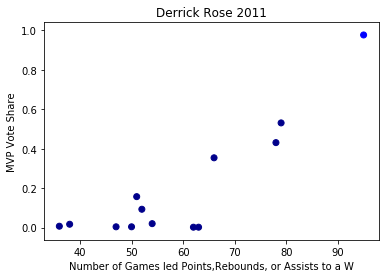

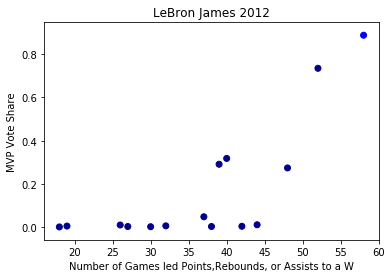

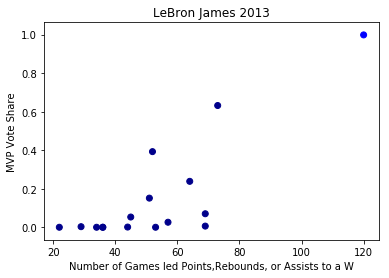

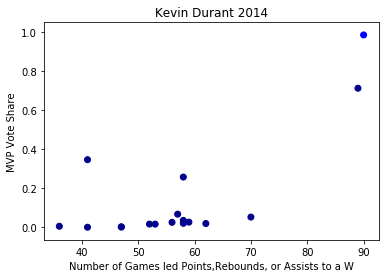

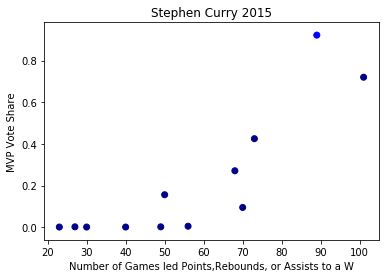

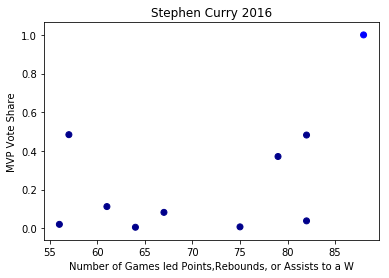

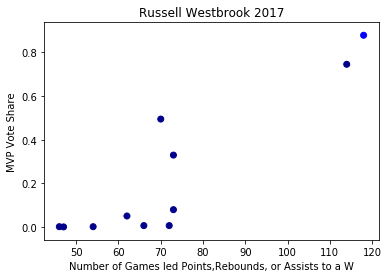

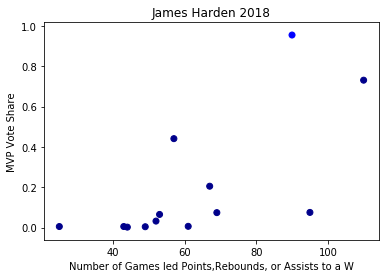

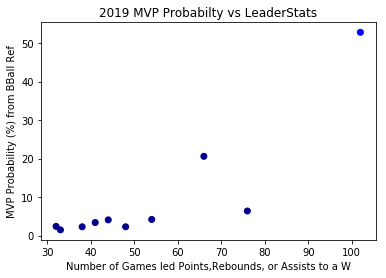

In [11]:
#PLOT OF EACH YEAR COMBINED COUNTING LEADER STATS, PTS+REB+AST RANK
from sklearn.linear_model import LinearRegression


#reg = LinearRegression().fit(X, y)

for i in range(2000,2020):
    #include losses:
    #plt.scatter(df_list[i-2000]["total_pra"],df_list[i-2000]["Share"],c=np.where(df_list[i-2000]["is_mvp"]==1,'red','green'))
    year=i-2000
    X=df_list[year]
    
    plt.scatter(df_list[i-2000]["pra"],df_list[i-2000]["Share"],c=np.where(df_list[i-2000]["is_mvp"]==1,'blue','darkblue'))
    plt.xlabel("Number of Games led Points,Rebounds, or Assists to a W")
    if i!=2019:
        plt.ylabel("MVP Vote Share")
        plt.title(df_list[i-2000][df_list[i-2000]['is_mvp']==1].index.item()+" "+ str(i))
    else:
        plt.ylabel("MVP Probability (%) from BBall Ref")
        plt.title("2019 MVP Probabilty vs LeaderStats")
    plt.show()
    

In [20]:
#Uses Plotly to graph a full season of leaderdata -in wins only
def graph_season(year):
    season_dates=dates[year-2020]
    graph_leaders(season_dates[0], season_dates[1], season_dates[2], season_dates[3], season_dates[4], season_dates[5])
graph_season(2018)

Creating new leader dataset for your date range
Done scraping day: 10 17 2017
Done scraping day: 10 18 2017
Done scraping day: 10 19 2017
Done scraping day: 10 20 2017


KeyboardInterrupt: 